# 27Al CQ prediction with SOAP features

In [1]:
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
from pymatgen.io import ase
from pymatgen.io import ase
import matplotlib.pyplot as plt
import seaborn as sns
from pymatgen.core.structure import Structure as ST
from src.Utility import get_composition

In [2]:
# Read processed data and continue
with open("./data/processed_data_0.5.json", "r") as file:
    data_reload = json.load(file)
for data in data_reload:
    data['structure'] = ST.from_dict(data['structure'])
print("length of data set is:", len(data_reload))

length of data set is: 1681


In [3]:
# Atom Species
def get_species(data):
    """
    List all the atomic species in the data set.

    Args:
        data (dict): structure_tensors dict.
    """
    occur = []
    for structure_tensor in data:
        compo = get_composition(structure_tensor['structure'])
        occur.extend(compo)
        species = list(set(occur))
    return((species))
species = get_species(data_reload)
print("num of species in the data set:",len(species))

num of species in the data set: 76


In [4]:
from dscribe.descriptors import SOAP
from itertools import combinations_with_replacement


def getSOAPforStruct(structure_tensor, species, rCut=3, nMax=12, Lmax=9):
    """
    Get the SOAP descriptor for a given structure.

    Args:
        structure_tensor (dict): dict of structure and tensor information.
        species (list): list of species in the data set that current structure belongs to.
        rCut (int, optional): A cutoff for local region in angstroms. 
                              Should be bigger than 1 angstrom for the gto-basis. Defaults to 3.
        nMax (int, optional): The number of radial basis functions. Defaults to 12.
        Lmax (int, optional): The maximum degree of spherical harmonics. Defaults to 9.

    Returns:
        [type]: [description]
    """

    # Get structure and atom coord
    atoms = ase.AseAtomsAdaptor.get_atoms(structure_tensor["structure"])

    # initialize SOAP
    species = species
    rcut = rCut
    nmax = nMax
    lmax = Lmax

    # Setting up the SOAP descriptor
    soap = SOAP(
        species=species,
        periodic=True,
        rcut=rcut,
        nmax=nmax,
        lmax=lmax,
        crossover=True,
        sparse=True,
    )

    # Get the coordination of Al atom to create SOAP on. 
    coord = []
    for tensor in structure_tensor["tensors"]:
        coord.append(tensor["site_coord"])

    location_dict = {}
    for combo in combinations_with_replacement(species, 2):
        loc = soap.get_location(combo)
        location_dict[combo] = loc

    x = soap.create(atoms, positions=coord)

    return (x.tocsr(), location_dict)

In [5]:
def TensorSOAPcombo(structure_tensor, nmr_key, species):
    """[summary]

    Args:
        structure_tensor ([type]): [description]
        nmr_key ([type]): [description]
        species ([type]): [description]

    Returns:
        [type]: [description]
    """
    x, loc = getSOAPforStruct(structure_tensor, species)
    y = []
    for tensor in structure_tensor["tensors"]:
        y.append([tensor[nmr_key], structure_tensor["structure"], tensor["site_index"]])
    return (x, y, loc)

In [6]:
# getXY when choose sparse matrix in soap
from scipy.sparse import vstack
from random import sample
def getXY(structures_tensors,species):
    #loctaion info for slice the soap vector, None when choose other descriptor
    loc = None
    X=None
    y=[]
    
    for item in tqdm(structures_tensors):
        soap, nmr_param, loc = TensorSOAPcombo(item,'CQ',species = species)
        if X==None:
            X =soap
        else:
            X = vstack([X,soap])
        y.extend(nmr_param)
    
    y = pd.DataFrame(y,columns=['nmr','structure','site_index'])
    
    return(X,y,loc)

In [7]:
X,y,loc = getXY(data_reload,species)
print(X.shape,y.shape)

100%|██████████| 1681/1681 [28:30<00:00,  1.02s/it]

(8081, 4163280) (8081, 3)


In [8]:
from sklearn.decomposition import TruncatedSVD
N = 100
pca = TruncatedSVD(n_components=N,algorithm="arpack")
X_pca_fit = pca.fit(X)
X_pca = X_pca_fit.transform(X)

print(f"PCA covers {sum(X_pca_fit.explained_variance_ratio_)}% of variance")
print (f'PCA done! New shape {X_pca.shape}')

PCA covers 0.9822579904048121% of variance
PCA done! New shape (8081, 100)


In [9]:
# Get absolute value of CQ
y['nmr'] = abs(y['nmr'])

# Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2,random_state=10)

print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(6464, 100) (6464, 3) (1617, 100) (1617, 3)


In [10]:
%%time
# Grid Search for Algorithm Tuning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import math

# create and fit a kernel ridge regression model
model = RandomForestRegressor(random_state=10,min_samples_split=4,min_samples_leaf=2)

param = {"n_estimators": randint(low=100, high=500), 
         "max_depth": uniform(10, 200),
         "max_features": ['auto', 'sqrt','log2']
         }

grid = RandomizedSearchCV(
    estimator=model,
    param_distributions=param,
    n_iter=10,
    scoring=["neg_mean_absolute_error", "neg_mean_squared_error", "r2"],
    refit="r2",
    cv=5,
    n_jobs=8,
)

grid.fit(X_train, y_train['nmr'])

# summarize the results of the grid search
train_r2 = np.sort(grid.cv_results_['mean_test_r2'])[-1]
train_RMSE = math.sqrt(-np.sort(grid.cv_results_['mean_test_neg_mean_squared_error'])[-1])
train_MAE = -np.sort(grid.cv_results_['mean_test_neg_mean_absolute_error'])[-1]

print('training score: R2 = {}, RMSE = {}, MAE = {}'.format(train_r2, train_RMSE, train_MAE))
print(grid.best_estimator_)

training score: R2 = 0.8897301850853786, RMSE = 1.3174446318061697, MAE = 0.5863204781122461
RandomForestRegressor(max_depth=94.96969160063206, min_samples_leaf=2,
                      min_samples_split=4, n_estimators=372, random_state=10)
CPU times: user 2min 14s, sys: 3.53 s, total: 2min 17s
Wall time: 9min 21s


test scores: R2 = 0.8989817749052339, RMSE = 1.3383310244783126, MAE = 0.5251042344749536
date and time: 15-10-2021_01-19-43


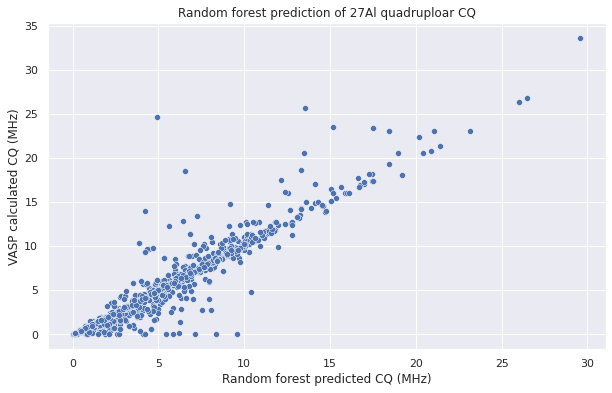

CPU times: user 484 ms, sys: 141 ms, total: 625 ms
Wall time: 377 ms


In [16]:
%%time
# Predict test set
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
sns.set()

y_rf = grid.predict(X_test)
y_test = y_test

test_r2 = r2_score(y_test, y_rf)
test_RMSE = math.sqrt(mean_squared_error(y_test, y_rf))
test_MAE = mean_absolute_error(y_test, y_rf)

print("test scores: R2 = {}, RMSE = {}, MAE = {}".format(test_r2, test_RMSE, test_MAE))


# write down the date for png save
predict_result = {}
predict_result["VASP_CQ"] = y_test
predict_result["RF_predicted_CQ"] = y_rf
predict_result = pd.DataFrame(predict_result)

# datetime object containing current date and time
now = datetime.now() 
# dd/mm/YY H:M:S
dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")
print("date and time:",dt_string)

plt.figure(figsize=[10, 6])
plt.title("Random forest regression of 27Al CQ")
plot = sns.scatterplot(
    x="RF_predicted_CQ",
    y="VASP_CQ",
    data=predict_result,
)
plt.gca().set(title='Random forest prediction of 27Al quadruploar CQ', 
                xlabel="Random forest predicted CQ (MHz)",ylabel="VASP calculated CQ (MHz)")
# plt.savefig('./figures/27Al_RF_testSet_{}.png'.format(dt_string))
plt.show()